# LLM Prisoner's Dilemma

In [1]:
#LLM Config
from dotenv import load_dotenv
import os
import openai
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
import time
import csv
import re
import logging
import random

load_dotenv()
openai_apikey = os.getenv('YOUR_OPENAI_API_KEY')
openai_url = os.getenv('OPENAI_BASE_URL')

################################## Main CONFIG HERE #######################################

# For Ollama client info
OLLAMA_BASE_URL = "http://localhost:11434/v1"  # Example: adjust to your local server
OLLAMA_API_KEY = "ollama"  # placeholder but required by the client

#SET the models to use
AGENT1_API = "openai" #ollama / openai
AGENT1_MODEL = "claude-3-7-sonnet-thinking" #ollama / openai models / or any models if having a universal testing api (gpt-4o; claude-3-7-sonnet-thinking; deepseek-reasoner; deepseek-r1; grok-3; claude-3-7-sonnet-thinking)

AGENT2_API = "openai" #ollama / openai / random / human (random and human can be used for both AGENT1 and AGENT2)
AGENT2_MODEL = "grok-3-reasoner" #ollama / openai models / ramdom_agent / human_player

#set total number of rounds
TOTAL_ROUND_NUMBER = 10
EXAMPLE_ROUNDS = 10 #10 or 50 atm

#LLM Max Token
MAX_TOKEN = 500 #it is totally fine to set this to 10 or even 5, assuming the the LLM will only respond with a letter C or D

MAX_CONN_RETRIES = 10 #number of retries if there is connection error through api
RETRY_DELAY = 150 # delay time between each retry, in seconds

#Set Temperature
TEMPERATURE = 0

#TWIST the original game rule of not
RULETWIST = True #Add rules becuase of multiple rounds
RNUM_KNOWN = True #whether the LLM will know the total number of rounds to play
COMPETITIVE = True #whether the goal is to attain fewer number of years in person than the opponent
HUMANRDEXP = 2 #whether example games are added to prompt (0: Do not add; 1: add to first agent, 2: add to both agents)

#Current TIMESTAMP
CURRENT_TIMESTAMP = str(int(time.time()))
################################## End Main CONFIG #######################################

OPENAI_CHAT_CLIENT = OpenAI(base_url=openai_url, api_key=openai_apikey)
OLLAMA_CHAT_CLIENT = OpenAI(base_url=OLLAMA_BASE_URL, api_key=OLLAMA_API_KEY)

roundbased_filename = ""
if not RULETWIST:
    roundbased_filename = "roundbased_reset_"

knownrounds_filename = ""
if RNUM_KNOWN:
    knownrounds_filename = "knownrounds_"

competitive_filename = ""
if COMPETITIVE:
    competitive_filename = "competitive_"

human_exp = ""
human_filename = ""
if HUMANRDEXP == 1:
    human_filename = "hexp_"
elif HUMANRDEXP == 2:
    human_filename = "hexpBOTH_"

if HUMANRDEXP > 0 and HUMANRDEXP <= 2:
    if EXAMPLE_ROUNDS == 10:
        human_exp = """
            
                Here are results of some previous games for you to formulate your winning strategy:
        
                Previous Game 1:
                Player 1\tPlayer 2
                C\t\tD
                D\t\tD
                D\t\tC
                D\t\tD
                D\t\tD
                D\t\tD
                C\t\tD
                C\t\tC
                D\t\tD
                C\t\tD
                Results - Player 1: 20 years; Player 2: 14 years
                After Reward / Penalty - Player 1: -10 years; Player 2: 14 years
                Player 1 wins
        
                Previous Game 2:
                Player 1\tPlayer 2
                C\t\tD
                C\t\tD
                D\t\tD
                D\t\tD
                D\t\tD
                D\t\tD
                D\t\tD
                D\t\tD
                D\t\tD
                D\t\tD
                Results - Player 1: 22 years; Player 2: 16 years
                After Reward / Penalty - Player 1: -8 years; Player 2: 16 years
                Player 1 wins
        
                Previous Game 3:
                Player 1\tPlayer 2
                C\t\tD
                C\t\tD
                D\t\tD
                D\t\tD
                D\t\tS
                D\t\tD
                D\t\tD
                D\t\tC
                D\t\tD
                D\t\tD
                Results - Player 1: 18 years; Player 2: 18 years
                After Reward / Penalty - Player 1: 68 years; Player 2: 68 years
                Draw, no one wins
            """
    if EXAMPLE_ROUNDS == 50:
        human_exp = """
        
            Here are results of some previous games for you to formulate your winning strategy:
    
            Previous Game 1:
            Player 1\tPlayer 2
            D\t\tC
            D\t\tC
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            Results - Player 1: 96 years; Player 2: 72 years
            Player 2 wins
    
            Previous Game 2:
            Player 1\tPlayer 2
            C\t\tC
            C\t\tC
            D\t\tC
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tC
            Results - Player 1: 94 years; Player 2: 70 years
            Player 2 wins
    
            Previous Game 3:
            Player 1\tPlayer 2
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            C\t\tD
            C\t\tC
            C\t\tC
            D\t\tC
            C\t\tC
            D\t\tD
            D\t\tD
            C\t\tC
            D\t\tD
            C\t\tC
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            C\t\tC
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            C\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            C\t\tC
            63\t\t90
            Results - Player 1: 63 years; Player 2: 90 years
            Player 1 wins
            
            Previous Game 4:
            Player 1\tPlayer 2
            C\t\tC
            D\t\tD
            C\t\tD
            D\t\tC
            C\t\tD
            D\t\tD
            C\t\tC
            D\t\tD
            D\t\tC
            C\t\tC
            D\t\tD
            C\t\tD
            D\t\tD
            C\t\tD
            C\t\tC
            C\t\tC
            C\t\tC
            C\t\tC
            D\t\tC
            D\t\tC
            C\t\tC
            C\t\tC
            C\t\tC
            D\t\tC
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            D\t\tD
            C\t\tD
            Results - Player 1: 135 years; Player 2: 135 years
            A Draw, No player wins.
        """

In [2]:
################################## DEFINE The PROMPT #######################################

#Prompts passing to the LLMs

###########################################################################################

if COMPETITIVE:
    competitive_prompt = "Your goal is to be in prison for a shorter period than your opponent, and minimize your years in prison while maximizing your opponent's."
else:
    competitive_prompt = "Your goal is to minimize your total years in prison over the course of the game."

if RULETWIST and not RNUM_KNOWN:
    prompt1 = f"""
                You are playing an iterated Prisoner's Dilemma game. In each round, you and the other player will choose to either cooperate ('C') or defect ('D'). Your choices directly determine the years added to your prison sentences based on the following rules:
        
                    -If both of you choose 'C' (cooperate): Each of you receives 1 year in prison for that round.
                    -If you choose 'C' (cooperate) and the other chooses 'D' (defect): You receive 3 years in prison, and the other receives 0 years for that round.
                    -If you choose 'D' (defect) and the other chooses 'C' (cooperate): You receive 0 years in prison, and the other receives 3 years for that round.
                    -If both of you choose 'D' (defect): Each of you receives 2 years in prison for that round.
    
                The game consists of multiple rounds, and your total years in prison will be the sum of the years accumulated from each round. You will not know the total number of rounds to play.
                
                    -When all the rounds end, there will be a penalty of 50 years in prison if the number of years in prison of you and your opponent is the same.
                    -The one with higher number of years in prison after all rounds end will have a reward of -30 years. 
                
                {competitive_prompt} Be sure to consider the previous moves of you and your opponent. Your opponent may not think in the same way as you think. English language should be used.
            """
elif RULETWIST and RNUM_KNOWN:
    prompt1 = f"""
                You are playing an iterated Prisoner's Dilemma game. In each round, you and the other player will choose to either cooperate ('C') or defect ('D'). Your choices directly determine the years added to your prison sentences based on the following rules:
        
                    -If both of you choose 'C' (cooperate): Each of you receives 1 year in prison for that round.
                    -If you choose 'C' (cooperate) and the other chooses 'D' (defect): You receive 3 years in prison, and the other receives 0 years for that round.
                    -If you choose 'D' (defect) and the other chooses 'C' (cooperate): You receive 0 years in prison, and the other receives 3 years for that round.
                    -If both of you choose 'D' (defect): Each of you receives 2 years in prison for that round.
    
                The game consists of multiple rounds, and your total years in prison will be the sum of the years accumulated from each round.
                
                    -When all the rounds end, there will be a penalty of 50 years in prison if the number of years in prison of you and your opponent is the same.
                    -The one with higher number of years in prison after all rounds end will have a reward of -30 years. 
                {human_exp}
                {competitive_prompt} Be sure to consider the previous moves of you and your opponent. Your opponent may not think in the same way as you think. English language should be used.
            """
else:
    prompt1 = f"""
                You are playing the Prisoner's Dilemma game. In each round, you and the other player will choose to either cooperate ('C') or defect ('D'). Your choices directly determine the years added to your prison sentences based on the following rules:
        
                    -If both of you choose 'C' (cooperate): Each of you receives 1 year in prison for that round.
                    -If you choose 'C' (cooperate) and the other chooses 'D' (defect): You receive 3 years in prison, and the other receives 0 years for that round.
                    -If you choose 'D' (defect) and the other chooses 'C' (cooperate): You receive 0 years in prison, and the other receives 3 years for that round.
                    -If both of you choose 'D' (defect): Each of you receives 2 years in prison for that round.
    
                The game consists of multiple rounds, and your total years in prison will be the sum of the years accumulated from each round.
                Your goal is to minimize the number of years in prison of this particular round, no matter what your opponent chooses. English language should be used.
            """


#PROMPT for agent 2
prompt2 = prompt1

if HUMANRDEXP == 1:
    if RULETWIST and RNUM_KNOWN:
        prompt2 = f"""
                    You are playing an iterated Prisoner's Dilemma game. In each round, you and the other player will choose to either cooperate ('C') or defect ('D'). Your choices directly determine the years added to your prison sentences based on the following rules:
            
                        -If both of you choose 'C' (cooperate): Each of you receives 1 year in prison for that round.
                        -If you choose 'C' (cooperate) and the other chooses 'D' (defect): You receive 3 years in prison, and the other receives 0 years for that round.
                        -If you choose 'D' (defect) and the other chooses 'C' (cooperate): You receive 0 years in prison, and the other receives 3 years for that round.
                        -If both of you choose 'D' (defect): Each of you receives 2 years in prison for that round.
        
                    The game consists of multiple rounds, and your total years in prison will be the sum of the years accumulated from each round.
                    
                        -When all the rounds end, there will be a penalty of 50 years in prison if the number of years in prison of you and your opponent is the same.
                        -The one with higher number of years in prison after all rounds end will have a reward of -30 years. 
    
                    {competitive_prompt} Be sure to consider the previous moves of you and your opponent. Your opponent may not think in the same way as you think. English language should be used.
                """

In [3]:
################################## LOGGING HANDLER #######################################

#Handling logs

###########################################################################################

# Set up the logger
logger = logging.getLogger('simulation')
logger.setLevel(logging.INFO)

# Create a console handler to display output in the console
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

# Define a formatter to mimic print behavior (just the message)
formatter = logging.Formatter('%(message)s')
console_handler.setFormatter(formatter)

# Add the console handler to the logger
logger.addHandler(console_handler)

In [4]:
################################## PAYOFF SETTING #######################################

#Set the pay offs

###########################################################################################
PAYOFFS = {
    ('C', 'C'): (1, 1),  # Both cooperate: 1 year each
    ('C', 'D'): (3, 0),  # You cooperate, other defects: 3 years for you, 0 for them
    ('D', 'C'): (0, 3),  # You defect, other cooperates: 0 years for you, 3 for them
    ('D', 'D'): (2, 2)   # Both defect: 2 years each
}

In [5]:
################################## HELPER FUNCTIONS #######################################

#These functions handle LLM interactions and choice parsing. Adjust them based on your specific API implementations.

###########################################################################################

def get_llm_response(prompt, model, api_type):
    """Get response from the specified LLM based on api_type, with retry logic."""
    max_retries = MAX_CONN_RETRIES
    retry_delay_seconds = RETRY_DELAY

    for attempt in range(max_retries):
        try:
            if api_type == "openai":
                # Original OpenAI call [cite: 71]
                response = OPENAI_CHAT_CLIENT.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": prompt}],
                    max_tokens=MAX_TOKEN,
                    temperature=TEMPERATURE
                )
                logger.info(f"response is - {response.choices[0].message.content}")
                return response.choices[0].message.content # Return on success
            elif api_type == "ollama":
                 # Original Ollama call [cite: 72]
                response = OLLAMA_CHAT_CLIENT.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": prompt}],
                    max_tokens=MAX_TOKEN,
                    temperature=TEMPERATURE
                )
                logger.info(f"response is - {response.choices[0].message.content}")
                return response.choices[0].message.content # Return on success
            else:
                # Original error handling for unsupported type
                raise ValueError("Unsupported api_type")

        except openai.APIConnectionError as e: # Catch specific connection errors
            logger.warning(f"API Connection Error (Attempt {attempt + 1}/{max_retries}): {e}. Retrying in {retry_delay_seconds} seconds...")
            if attempt + 1 == max_retries:
                logger.error("Maximum retry attempts reached. Failing.")
                raise # Re-raise the exception to stop the script
            time.sleep(retry_delay_seconds) # Wait before retrying
        except Exception as e: # Catch other potential errors during API call
             logger.error(f"An unexpected error occurred during API call: {e}")
             raise # Re-raise other errors immediately

    # This part should theoretically not be reached if max_retries > 0
    # but added for completeness.
    logger.error("Failed to get LLM response after multiple retries.")
    raise Exception("Failed to get LLM response after multiple retries.")

def clean_response(response):
    # Remove content within <think></think> tags
    response = re.sub(r'<think>.*?</think>', '', response, flags=re.DOTALL)
    # Remove content within <thinking></thinking> tags
    response = re.sub(r'<thinking>.*?</thinking>', '', response, flags=re.DOTALL)
    return response

def parse_choice(response):
    #clean content within <think></think> <thinking></thinking> tags
    response = clean_response(response)
    """Parse the LLM response to extract 'C' or 'D'."""
    patterns = [
        r"(?:I choose|My choice is|So my choice for this round is|I'm going to choose|I will choose|My choice will be)\s*['\"]?([CD])['\"]?",  # For phrases
        r"\b['\"]?([CD])['\"]?\b"  # For standalone 'C' or 'D'
    ]
        
        # Search for matches in the response
    for pattern in patterns:
        matches = re.findall(pattern, response)
        if matches:
            # Return the last match, which is likely the final choice
            logger.info(f"~~~~~NO FALLBACK: {matches[-1]}~~~~~")
            return matches[-1]
    logger.info("~~~~~FALLBACK CHOICE USED: D~~~~~")
    return 'D'  # Default to 'D' if unclear

In [6]:
################################## AGENT CLASS #######################################

#The Agent class stores the model, API type, and prompt, and provides a method to make decisions.

###########################################################################################

class Agent:
    def __init__(self, model, api_type, prompt):
        self.model = model
        self.api_type = api_type
        self.prompt = prompt
        self.history = []
        self.accumulative_payoff = 0

    def choose_action(self, round_num):
        # For random agents, skip the prompt construction and directly get a random choice
        if self.api_type == "random":
            choice = random.choice(['C', 'D'])
            logger.info(f"Random agent chose: {choice}")
            return choice        
        
        history_summary = "Previous rounds:\n"
        accumulative_self = 0
        accumulative_opponent = 0
    
        # Build history summary with per-round details
        for round_data in self.history:
            round_num_past, my_choice, opponent_choice, my_payoff = round_data
            # Calculate opponent's payoff using the PAYOFFS matrix
            opponent_payoff = PAYOFFS[(my_choice, opponent_choice)][1]
            
            accumulative_self += my_payoff
            accumulative_opponent += opponent_payoff
            
            history_summary += (
                f"Round {round_num_past}: You chose {my_choice}, "
                f"opponent chose {opponent_choice}, you got {my_payoff} years "
                f"(total: {accumulative_self}), opponent got {opponent_payoff} years "
                f"(total: {accumulative_opponent})\n"
            )
    
        # Handle case with no previous rounds
        if not self.history:
            history_summary += "No previous rounds.\n"
        else:
            history_summary += f"Your current total years in prison: {accumulative_self}\n"
            history_summary += f"Opponent's current total years in prison: {accumulative_opponent}\n"
    
        # Construct the full prompt
        total_round_prompt = ""
        if RNUM_KNOWN:
            total_round_prompt = f"There will be {TOTAL_ROUND_NUMBER} rounds in total. "
            
        full_prompt = f"""
    {self.prompt}
    
    Current round: {round_num}
    
    {history_summary}
    
    {total_round_prompt}What do you choose for this round? Just response 'C' or 'D' without any additional comments or explanations.
        """
    
        # For debugging purposes (optional)
        logger.info("=================================================================")
        logger.info(f"Prompt for {self.model} in Round {round_num}:\n{full_prompt}\n")
        logger.info("=================================================================")

        # For human players, show the prompt and get input
        if self.api_type == "human":
            print("\n=================================================================")
            print(full_prompt)
            print("=================================================================")
            
            while True:
                choice = input("Your choice (C/D): ").strip().upper()
                if choice in ['C', 'D']:
                    logger.info(f"Human player chose: {choice}")
                    return choice
                else:
                    print("Invalid choice. Please enter 'C' or 'D'.")
        
        # For LLM agents, use the normal flow
        
        response = get_llm_response(full_prompt, self.model, self.api_type)
        choice = parse_choice(response)
        return choice

    def update_history(self, round_num, my_choice, opponent_choice, payoff):
        """Update agent's history and accumulative payoff."""
        self.history.append((round_num, my_choice, opponent_choice, payoff))
        self.accumulative_payoff += payoff

In [7]:
################################## SIMULATION FUNCTION #######################################

#The simulate_game function runs the simulation, logs the agent configurations, and tracks the game progress.

###########################################################################################

def simulate_game(agent1, agent2, rounds=10):
    """Simulate the Prisoner's Dilemma with history tracking."""
    # Generate timestamp and filenames
    csv_filename = f"{agent1.model.replace(':', '')}_{agent2.model.replace(':', '')}_{roundbased_filename}{knownrounds_filename}{competitive_filename}{human_filename}{CURRENT_TIMESTAMP}.csv"
    log_filename = f"{agent1.model.replace(':', '')}_{agent2.model.replace(':', '')}_{roundbased_filename}{knownrounds_filename}{competitive_filename}{human_filename}{CURRENT_TIMESTAMP}.txt"

    # Create and configure the file handler
    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)  # Use the same formatter as the console
    logger.addHandler(file_handler)
    
    logger.info("Simulation Configuration:")
    logger.info(f"Agent 1: model={agent1.model}, api={agent1.api_type}, prompt='{agent1.prompt}'")
    logger.info(f"Agent 2: model={agent2.model}, api={agent2.api_type}, prompt='{agent2.prompt}'")
    logger.info("\nStarting Simulation...\n")
    
    payoffs1 = []
    payoffs2 = []

    #List to store data for CSV
    data = []
        
    for round_num in range(1, rounds + 1):
        # Agents choose actions based on opponent's history
        choice1 = agent1.choose_action(round_num)
        choice2 = agent2.choose_action(round_num)
        
        # Calculate payoffs
        payoff = PAYOFFS[(choice1, choice2)]
        payoffs1.append(payoff[0])
        payoffs2.append(payoff[1])
        
        # Update agent histories
        agent1.update_history(round_num, choice1, choice2, payoff[0])
        agent2.update_history(round_num, choice2, choice1, payoff[1])

        # Store data for this round
        data.append({
            'Round': round_num,
            'Choice of Agent1': choice1,
            'Choice of Agent2': choice2,
            'Agent1 Years Received': payoff[0],
            'Agent2 Years Received': payoff[1],
            'Agent1 Accumulated Years': agent1.accumulative_payoff,
            'Agent2 Accumulated Years': agent2.accumulative_payoff
        })
        
        logger.info(f"Round {round_num}: Agent1 - {agent1.model} chose {choice1}, Agent2 - {agent2.model} chose {choice2}, Payoff: {payoff}")

    logger.info(f"\nTotal Payoff for Agent1: {agent1.accumulative_payoff}")
    logger.info(f"Total Payoff for Agent2: {agent2.accumulative_payoff}")

    if RULETWIST:
        # After all rounds, check for penalty
        if agent1.accumulative_payoff == agent2.accumulative_payoff:
            final_years = agent1.accumulative_payoff
            agent1.accumulative_payoff += 50
            agent2.accumulative_payoff += 50
            logger.info(f"Penalty applied: Both agents had equal totals ({final_years}), each receives +50 years.")
        elif agent1.accumulative_payoff > agent2.accumulative_payoff:
            agent1.accumulative_payoff -= 30
            agent2.accumulative_payoff = agent2.accumulative_payoff
            logger.info(f"Reward applied: Agent 1 {agent1.model} has higher total, receives -30 years.")
        elif agent2.accumulative_payoff > agent1.accumulative_payoff:
            agent2.accumulative_payoff -= 30
            agent1.accumulative_payoff = agent1.accumulative_payoff
            logger.info(f"Reward applied: Agent 2 {agent2.model} has higher total, receives -30 years.")

        # Append the final row
        data.append({
            'Round': 'Final',
            'Choice of Agent1': '',
            'Choice of Agent2': '',
            'Agent1 Years Received': '',
            'Agent2 Years Received': '',
            'Agent1 Accumulated Years': agent1.accumulative_payoff,
            'Agent2 Accumulated Years': agent2.accumulative_payoff
        })

    # Write results to CSV
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['Round', 'Choice of Agent1', 'Choice of Agent2', 
                      'Agent1 Years Received', 'Agent2 Years Received', 
                      'Agent1 Accumulated Years', 'Agent2 Accumulated Years']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for row in data:
            writer.writerow(row)
    
    print(f"\nResults saved to {csv_filename}")
    
    return payoffs1, payoffs2

In [8]:
################################## DATA PLOT FUNCTION #######################################

#Plot the cumulative payoffs

###########################################################################################

def plot_cumulative_payoffs(payoffs1, payoffs2, agent1_name, agent2_name):
    # Calculate cumulative payoffs over the rounds
    cumulative1 = np.cumsum(payoffs1)
    cumulative2 = np.cumsum(payoffs2)
    rounds = list(range(1, len(payoffs1) + 1))
    
    # Get the final cumulative totals
    final_cumulative1 = cumulative1[-1]
    final_cumulative2 = cumulative2[-1]

    if RULETWIST:
    # Apply penalty or reward
        if final_cumulative1 == final_cumulative2:
            # Penalty: both agents get +50 years
            final_cumulative1 += 50
            final_cumulative2 += 50
            # Add an extra point to show the adjustment
            rounds.append(len(payoffs1) + 1)
            cumulative1 = np.append(cumulative1, final_cumulative1)
            cumulative2 = np.append(cumulative2, final_cumulative2)
            print("Penalty applied: Both agents had equal totals, each receives +50 years.")
        elif final_cumulative1 > final_cumulative2:
            # Reward: agent1 gets -30 years
            final_cumulative1 -= 30
            rounds.append(len(payoffs1) + 1)
            cumulative1 = np.append(cumulative1, final_cumulative1)
            cumulative2 = np.append(cumulative2, final_cumulative2)
            print(f"Reward applied: {agent1_name} has higher total, receives -30 years.")
        elif final_cumulative2 > final_cumulative1:
            # Reward: agent2 gets -30 years
            final_cumulative2 -= 30
            rounds.append(len(payoffs1) + 1)
            cumulative1 = np.append(cumulative1, final_cumulative1)
            cumulative2 = np.append(cumulative2, final_cumulative2)
            print(f"Reward applied: {agent2_name} has higher total, receives -30 years.")

    # Plot the cumulative payoffs, including adjustments
    # Ensure x-axis labels are integers
    plt_filename = f"{agent1_name.replace(':', '')}_{agent2_name.replace(':', '')}_{roundbased_filename}{knownrounds_filename}{competitive_filename}{human_filename}{CURRENT_TIMESTAMP}.png"

    plt.figure(figsize=(8,6))
    #plt.xticks(rounds)
    #plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
    #plt.xticks(rotation=45)
    plt.plot(rounds, cumulative1, label=f"Player 1: {agent1_name}")
    plt.plot(rounds, cumulative2, label=f"Player 2: {agent2_name}")
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Years in Prison")
    plt.title("Cumulative Years in Prison Over Time")
    plt.legend()
    plt.grid(True)
    plt.savefig(plt_filename)  # Save as PNG
    plt.show()

Simulation Configuration:
Agent 1: model=claude-3-7-sonnet-thinking, api=openai, prompt='
                You are playing an iterated Prisoner's Dilemma game. In each round, you and the other player will choose to either cooperate ('C') or defect ('D'). Your choices directly determine the years added to your prison sentences based on the following rules:
        
                    -If both of you choose 'C' (cooperate): Each of you receives 1 year in prison for that round.
                    -If you choose 'C' (cooperate) and the other chooses 'D' (defect): You receive 3 years in prison, and the other receives 0 years for that round.
                    -If you choose 'D' (defect) and the other chooses 'C' (cooperate): You receive 0 years in prison, and the other receives 3 years for that round.
                    -If both of you choose 'D' (defect): Each of you receives 2 years in prison for that round.
    
                The game consists of multiple rounds, and your total year


Results saved to claude-3-7-sonnet-thinking_grok-3-reasoner_knownrounds_competitive_hexpBOTH_1744512403.csv
Reward applied: grok-3-reasoner has higher total, receives -30 years.


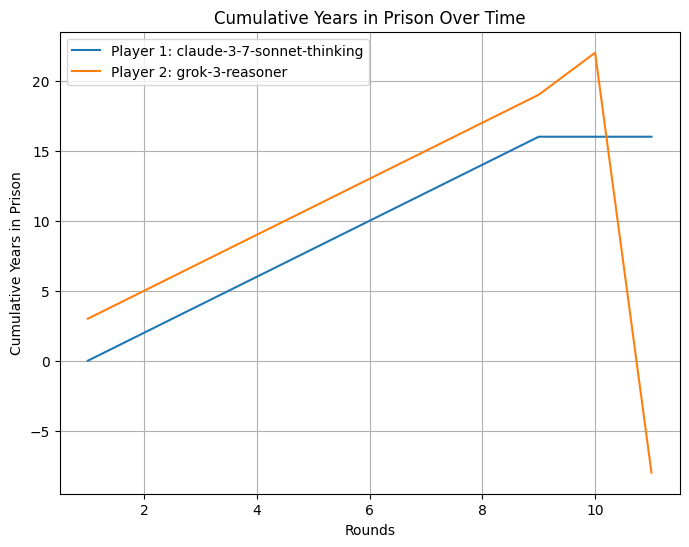

In [9]:
# Create agents with different models and prompts
agent1 = Agent(model=AGENT1_MODEL, api_type=AGENT1_API, prompt=prompt1) 
agent2 = Agent(model=AGENT2_MODEL, api_type=AGENT2_API, prompt=prompt2)

# Run the simulation
if __name__ == "__main__":
    payoffs1, payoffs2 = simulate_game(agent1, agent2, rounds=TOTAL_ROUND_NUMBER)
    plot_cumulative_payoffs(payoffs1, payoffs2, agent1.model, agent2.model)